In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import copy
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import cmocean as cmo
import matplotlib.pyplot as plt
import xarray as xr
import warnings
import cmocean
warnings.filterwarnings("ignore")

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

cwd=os.getcwd()

In [44]:
def sort_longitude(_x, lon_min=-180.):
    if lon_min is None:
        return _x
    lon_max=lon_min + 360.

    x = _x.copy()

    for lon in ['xh', 'xq', 'lon']:
        try:
            lon = x[lon]
            if lon.min() < lon_min:
                lon = xr.where(lon<lon_min, lon+360, lon)
                lon = xr.where(lon>lon_max, lon-360, lon)
            else:
                lon = xr.where(lon>lon_max, lon-360, lon)
                lon = xr.where(lon<lon_min, lon+360, lon)   
            x[lon.name] = lon.copy()
            
            x = x.sortby(lon.name)
        except:
            pass
    return x

In [50]:
# Read dt data from HarISST dataset
ds = sort_longitude(xr.open_dataset('/vast/pp2681/HadISST/HadISST_sst.nc').rename({'latitude': 'lat', 'longitude': 'lon'}), lon_min=-300.).sel(time=slice('1998', '2017'))
dt = np.diff(ds.time_bnds.values).reshape([240,1,1])

In [51]:
ds = sort_longitude(xr.open_dataset('/vast/pp2681/COBEv2_dataset/sst.mon.mean.nc'), lon_min=-300.).sel(time=slice('1998', '2017')).sortby('lat')
obs_sst_cobe = (ds.sst * dt).sum('time', skipna=False) / np.sum(dt)

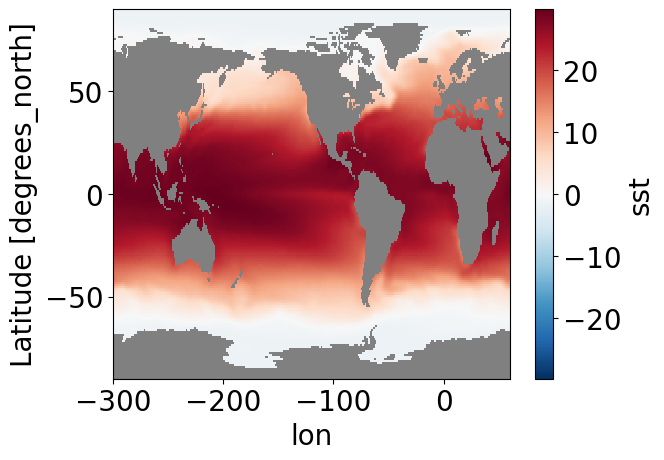

In [52]:
(obs_sst_cobe).plot()
plt.gca().set_facecolor('gray')

In [55]:
param = xr.open_dataset('/vast/pp2681/OM5/ocean_monthly.static.nc')

In [56]:
import xesmf as xe

coords_in = xr.Dataset()
coords_in['lon'] = param.geolon
coords_in['lat'] = param.geolat
coords_in['lon_b'] = param.geolon_c
coords_in['lat_b'] = param.geolat_c

coords_out = xr.Dataset()
lon, lat = obs_sst_cobe.lon, obs_sst_cobe.lat
coords_out['lon'] = lon
coords_out['lat'] = lat
# This is one-degree grid
coords_out['lon_b'] = xr.DataArray((lon + 0.5).values, dims='lon_b').pad({'lon_b':(1,0)}, mode='wrap')
coords_out['lat_b'] = xr.DataArray((lat + 0.5).values, dims='lat_b').pad({'lat_b':(1,0)}, mode='symmetric')

regridder_nearest = xe.Regridder(coords_in, coords_out, "nearest_s2d", ignore_degenerate=True, periodic=True)

In [57]:
ds = xr.open_dataset('/scratch/pp2681/Wenda-directory/om5b11_control/ocean_annual_z.1998-2017.ann.nc').isel(time=0)
control_sst = ds.thetao.isel(z_l=0)

ds = xr.open_dataset('/scratch/pp2681/Wenda-directory/ocean_annual_z.1998-2017.ann.nc').isel(time=0)
ann_sst = ds.thetao.isel(z_l=0)

# Final figures with 60-years runs

In [69]:
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker
def plot_sst(control, parameterized, obs, label, regions={}, global_rmse=False, obs_text='EN4',
            cbar_label='1998-2017 and 0-750m \naveraged pot. temperature [$\degree $C]',
            area=False):    
    
    plot_no=[1,2]
    
    fig = plt.figure(figsize=(15,5), layout='constrained')
    plt.rcParams['font.size'] = 20
    plt.rcParams['axes.titlesize'] = 20

    x, y = obs['lon'], obs['lat']
    lon,lat=np.meshgrid(x,y)

    def compute_rmse(data):
        if area:
            # This is array proportional to local area
            # on lat-lon grid. We add data*0 to
            # fill it with NaNs same as data
            dxdy = np.cos(np.deg2rad(data.lat)) + data*0
            return np.sqrt((data**2 * dxdy).sum(skipna=True) / dxdy.sum(skipna=True))
        else:
            return np.sqrt((data**2).mean(skipna=True))
        
    for i in plot_no:
        
        ax = fig.add_subplot(1, 2, i, projection=ccrs.PlateCarree(central_longitude=60))
        gl = gridlines = ax.gridlines(draw_labels=True, linewidth=0.5,alpha=1.0, linestyle='-')
        gl.xtop_labels = False
        gl.xlabels_top = False
        gl.ylabels_right = False  

        # Define your desired longitude ticks (degrees)
        xticks = [-60, 0, 60, 180]
        gl.xlocator = mticker.FixedLocator(xticks)
        
        if i==1:
            data = control - obs  ### load the data to be plotted
            rmse = compute_rmse(data)
            
            cmap = plt.cm.RdYlBu_r
            
            vmin,vmax,ci = -1.8,1.8,0.4
            cilev = np.arange(vmin,vmax+ci,ci)
            
            pcm=ax.contourf(lon,lat,data, transform=ccrs.PlateCarree(),cmap=cmap, levels=cilev, extend='both')
            pcm.set_rasterized(True)

            if global_rmse:
                ax.set_title(f'Control$-${obs_text}, global RMSE=%.3f $\degree $C' % rmse)
            else:
                ax.set_title(f'Control$-${obs_text}')

            for key, val in regions.items():
                lon_range, lat_range, color = val
                regional_rmse = compute_rmse(data.sel(lon=slice(*lon_range), lat=slice(*lat_range)))
                rect = Rectangle((lon_range[0], lat_range[0]), lon_range[1] - lon_range[0], lat_range[1] - lat_range[0],
                                 linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=100)
                ax.add_patch(rect)
                ax.text(lon_range[0] + 1, lat_range[0] - 15, 'RMSE=%.2f$\degree $C' % regional_rmse, color=color, fontsize=12,
                                 transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=1.0, edgecolor=color), zorder=100)
                
        elif i==2:
            gl.ylabels_left = False  
            
            data = parameterized[0].data - control.data  ### load the data to be plotted
            cmap = plt.cm.RdYlBu_r

            error = parameterized[0] - obs  ### load the data to be plotted
            rmse = compute_rmse(error)
            
            vmin,vmax,ci = -1.8,1.8,0.4
            cilev = np.arange(vmin,vmax+ci,ci)
            
            pcm=ax.contourf(lon,lat,data, transform=ccrs.PlateCarree(),cmap=cmap, levels=cilev, extend='both')
            pcm.set_rasterized(True)
            if global_rmse:
                ax.set_title(f'{label[0]}$-$Control, global RMSE=%.3f $\degree $C' % rmse)
            else:
                ax.set_title(f'{label[0]}$-$Control')

            for key, val in regions.items():
                lon_range, lat_range, color = val
                regional_rmse = compute_rmse(error.sel(lon=slice(*lon_range), lat=slice(*lat_range)))
                rect = Rectangle((lon_range[0], lat_range[0]), lon_range[1] - lon_range[0], lat_range[1] - lat_range[0],
                                 linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=100)
                ax.add_patch(rect)
                ax.text(lon_range[0] + 1, lat_range[0] - 15, 'RMSE=%.2f$\degree $C' % regional_rmse, color=color, fontsize=12,
                                 transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=1.0, edgecolor=color), zorder=100)
            
        ax.set_facecolor('gray')
        ax.coastlines(rasterized=True)
    
    cbar = plt.colorbar(pcm, ax=plt.gca().axes, orientation='vertical', shrink=0.7)
    cbar.set_label(cbar_label, fontsize=16)
    cbar.ax.xaxis.set_tick_params(labelrotation=45)

In [70]:
robs = sort_longitude(obs_sst_cobe, -120).compute()
rcontrol = sort_longitude(regridder_nearest(control_sst),-120).compute()
rann = sort_longitude(regridder_nearest(ann_sst),-120).compute()

rcontrol = xr.where(np.isnan(robs), np.nan, rcontrol)
rann = xr.where(np.isnan(robs), np.nan, rann)

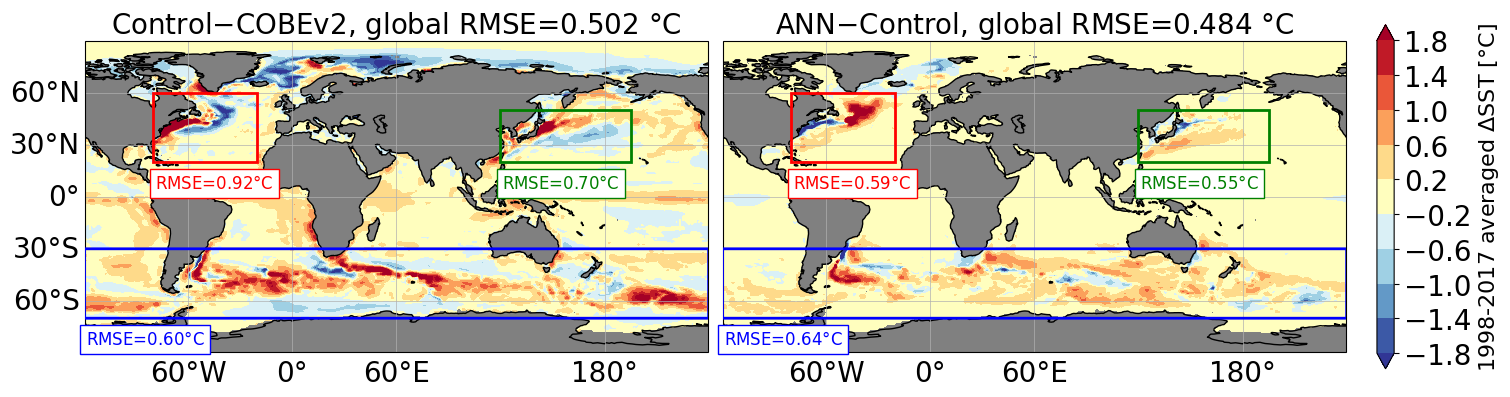

In [71]:
regions={'Kuroshio': ((120,195), (20, 50), 'g'),
         'Gulf': ((-80,-20), (20, 60), 'r'),
         'ACC': ((-120,240), (-70, -30), 'b')}

plot_sst(rcontrol, [rann], robs, label=['ANN'], 
         regions=regions, obs_text='COBEv2', 
         global_rmse=True, cbar_label='1998-2017 averaged $\Delta$SST [$\degree $C]',
         area=True)
plt.savefig('Figures-OM5/SST-COBE.pdf', bbox_inches='tight', dpi=150)